In [227]:
# import modules

import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
from geopy.distance import vincenty
import re
import statsmodels.formula.api as sm
from scipy.stats import gaussian_kde
%pylab inline

# load yelp API

from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator

# read API keys
with open('config_secret.json') as cred:
    creds = json.load(cred)
    auth = Oauth1Authenticator(**creds)
    client = Client(auth)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [17]:
# read yelp data from file

yelpdf = pd.read_csv('yelpdf.csv', index_col=0)

In [27]:
# read NYC felonies data from file

crimedf = pd.read_csv('NYPD_7_Major_Felony_Incident_Map.csv', index_col=0)

In [210]:
# use only 2015 incidents

crimedf2015=crimedf[crimedf['Occurrence Year']==2015]

In [216]:
# convert crime dataframe text lat/long coordinates to float tuples. 
# need to split the string into the lat and long numbers, convert into floats and then combine them into tuples.

tupler = lambda x: tuple(map(float, str.split(x[1:-1], sep=',')))

crimedf2015['lat_long']=crimedf2015['Location 1'].apply(tupler)

/Users/Heikal/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [217]:
# create float tuple coordinates from yelp latitude, longitude data

yelpdf['lat_long'] = yelpdf[['latitude', 'longitude']].apply(tuple, axis=1)

In [2]:
# read combined yelp and crime data csv

yelpcrimedf = pd.read_csv('yelpcrimedf.csv', index_col=0)

In [ ]:
crime

In [3]:
# abbreviate crime names

felonyfull=list(yelpcrimedf.columns[-7:])
felonyabbrv=['BUR','ASS','LAR','GTA','MUR','RAP','ROB']
felony_ref=pd.DataFrame({'code':felonyabbrv, 'full_name':felonyfull})
print(felony_ref)

  code                       full_name
0  BUR                        BURGLARY
1  ASS                  FELONY ASSAULT
2  LAR                   GRAND LARCENY
3  GTA  GRAND LARCENY OF MOTOR VEHICLE
4  MUR  MURDER & NON-NEGL. MANSLAUGHTE
5  RAP                            RAPE
6  ROB                         ROBBERY


In [4]:
# rename crime columns with 3 letter code

yelpcrimedf.rename(columns=dict(zip(felony_ref.full_name, felony_ref.code)), inplace=True)

In [5]:
# sum of felonies by business

yelpcrimedf['TOT']=yelpcrimedf[felonyabbrv].sum(axis=1)

In [211]:
# breakdown of crime by type
felname=[]
felcount=[]
for felony in felony_ref.full_name:
    felname.append(felony_ref.code[felony_ref.full_name==felony].values[0])
    felcount.append(sum(crimedf2015.Offense==felony))

feltable=pd.DataFrame({'felony':felname, 'number_of_felonies': felcount})

In [212]:
feltable['pct']=feltable.number_of_felonies/sum(feltable.number_of_felonies)

feltable=feltable.sort('number_of_felonies', ascending=False)

,felony,number_of_felonies,pct
2,LAR,15545,0.597081
1,ASS,3533,0.135702
6,ROB,3135,0.120415
0,BUR,2737,0.105128
3,GTA,799,0.030689
5,RAP,247,0.009487
4,MUR,39,0.001498


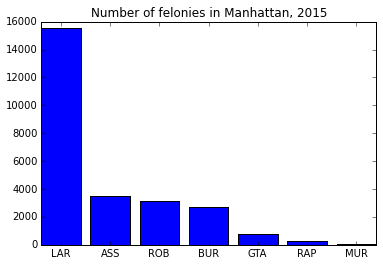

In [213]:
x = range(len(feltable))
y = feltable.number_of_felonies
fig, ax = plt.subplots()

ax.set_xticks(x)
ax.set_xticklabels(list(feltable.felony))
ax.set_title('Number of felonies in Manhattan, 2015')
B=ax.bar(x, y, align='center')
feltable

,felony,number_of_felonies,pct
2,LAR,15545,0.597081
1,ASS,3533,0.135702
6,ROB,3135,0.120415
0,BUR,2737,0.105128
3,GTA,799,0.030689
5,RAP,247,0.009487
4,MUR,39,0.001498


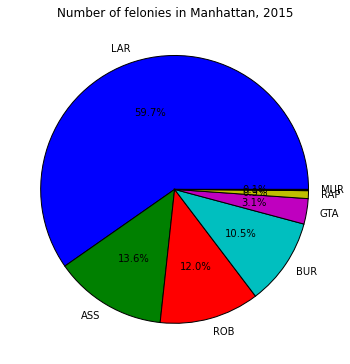

In [214]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_title('Number of felonies in Manhattan, 2015')
P=ax.pie(feltable.number_of_felonies, labels=list(feltable.felony), autopct='%1.1f%%')
feltable

/Users/Heikal/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


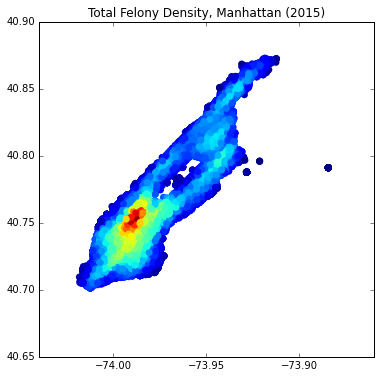

In [260]:
#KDE for all felonies

x,y = zip(*crimedf2015.lat_long)
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Total Felony Density, Manhattan (2015)')
ax.scatter(y, x, c=z, s=50, edgecolor='')
plt.show()


/Users/Heikal/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


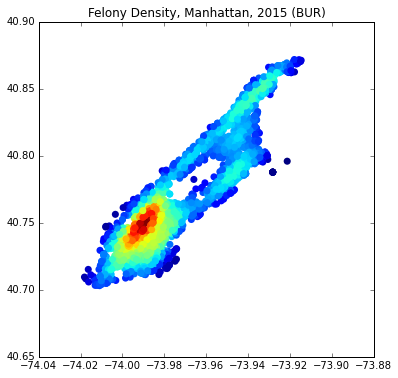

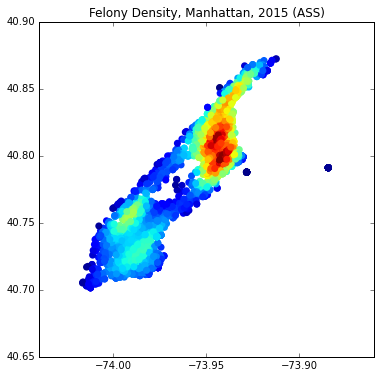

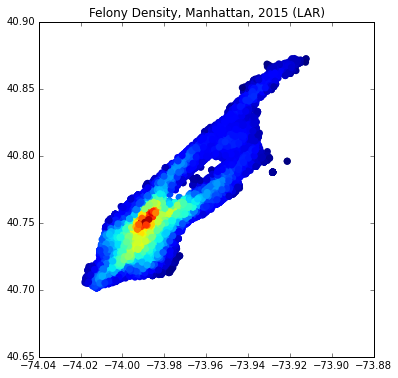

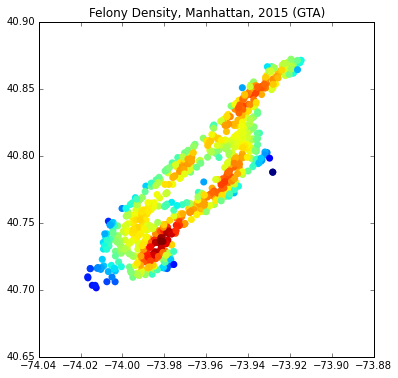

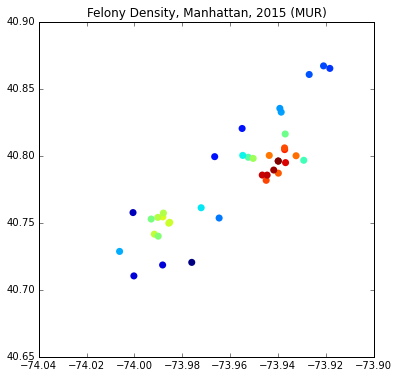

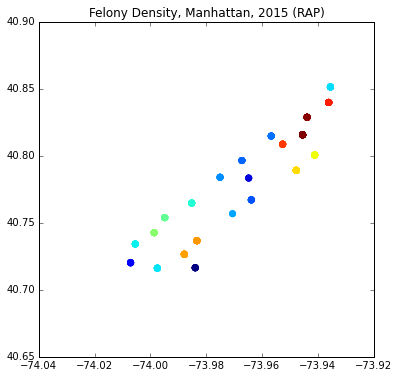

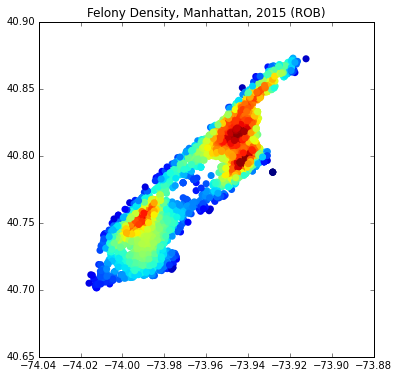

In [284]:
# KDE for felony by type of felony

for ref in felony_ref.code:
    x,y = zip(*crimedf2015.lat_long[crimedf2015.Offense==list(felony_ref.full_name[felony_ref.code==ref])[0]])
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title('Felony Density, Manhattan, 2015 (' + ref +')')
    ax.scatter(y, x, c=z, s=50, edgecolor='')
    plt.show()
    

In [ ]:
# pie chart for yelp bars by rating

fig, ax = plt.subplots(figsize=(6, 6))

ax.set_title('Number of felonies in Manhattan, 2015')
P=ax.pie(feltable.number_of_felonies, labels=list(feltable.felony), autopct='%1.1f%%')
feltable

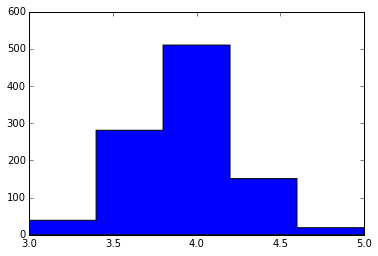

In [383]:
# histogram of ratings

fig, ax = plt.subplots()

H = ax.hist(yelpcrimedf['rating'], bins=5, histtype='stepfilled')

/Users/Heikal/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


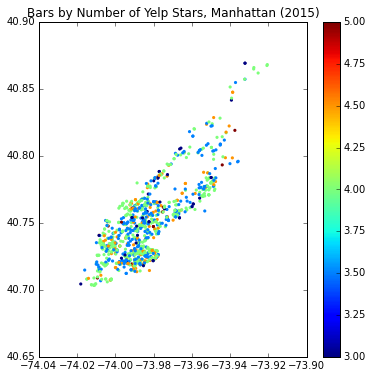

In [348]:
# Colormap for yelp stars

x,y = zip(*yelpdf.lat_long)
z = yelpdf.rating


fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Bars by Number of Yelp Stars, Manhattan (2015)')
cax=ax.scatter(y, x, c=z, s=10, edgecolor='')
fig.colorbar(cax)
plt.show()

/Users/Heikal/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


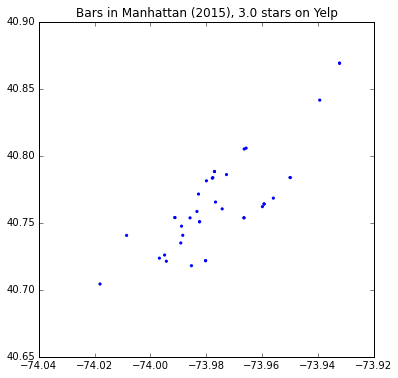

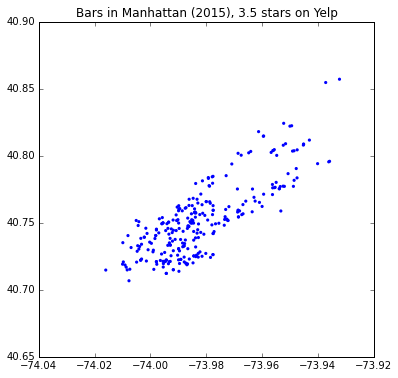

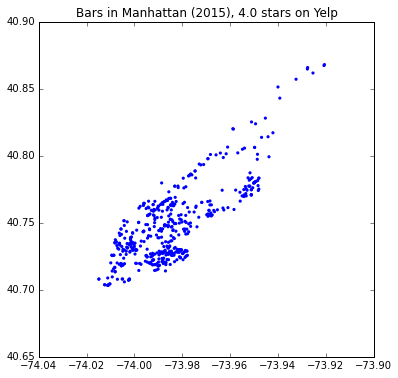

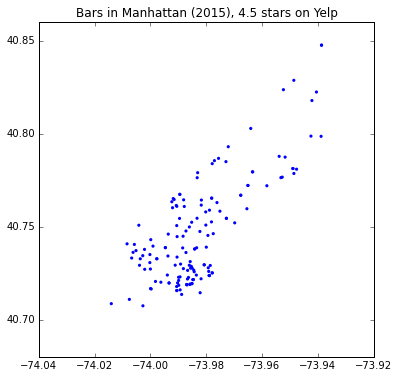

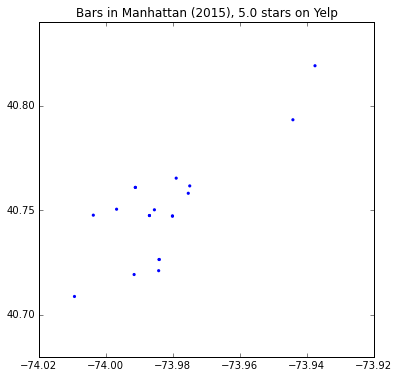

In [315]:
for stars in [3.0,3.5,4.0,4.5,5.0]:
    x,y = zip(*yelpdf[yelpdf.rating==stars].lat_long)
    z = yelpdf.rating


    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title('Bars in Manhattan (2015), ' + str(stars) + ' stars on Yelp')
    cax=ax.scatter(y, x, s=10, edgecolor='')
    plt.show()
    

/Users/Heikal/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


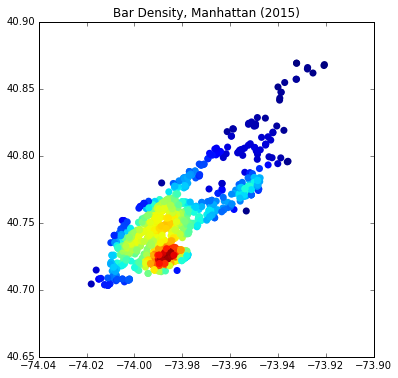

In [344]:
# KDE for yelp bars

x,y = zip(*yelpdf.lat_long)
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Bar Density, Manhattan (2015)')
ax.hexbin(y, x, c=z, s=50, edgecolor='')
plt.show()

count    1000.000000
mean      369.766000
std       177.480147
min         1.000000
25%       243.000000
50%       348.000000
75%       447.000000
max      1068.000000
Name: TOT, dtype: float64


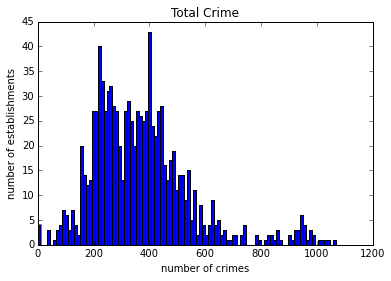

In [318]:
# show crime index histogram for all crimes

fig, ax = plt.subplots()
ax.set_title('Total Crime')
ax.set_xlabel('number of crimes')
ax.set_ylabel('number of establishments')

H = ax.hist(yelpcrimedf['TOT'], bins=100)

yelpcrimedf['TOT'].describe()

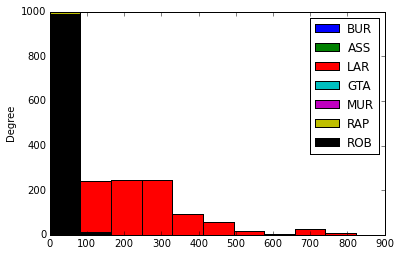

In [378]:
# histogram by various felony types

plt.figure()

yelpcrimedf[felony_ref.code].plot(kind='hist')

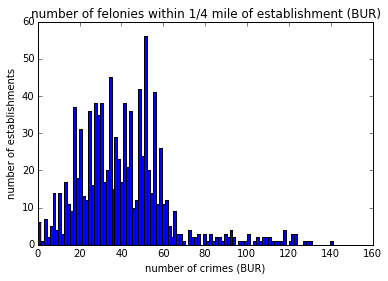

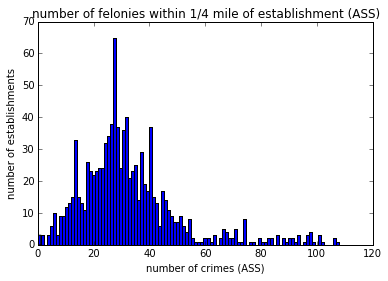

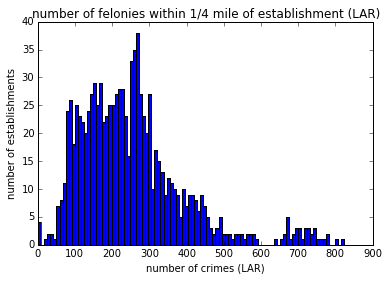

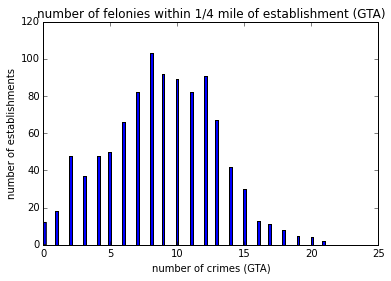

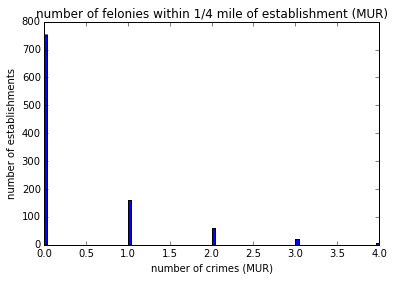

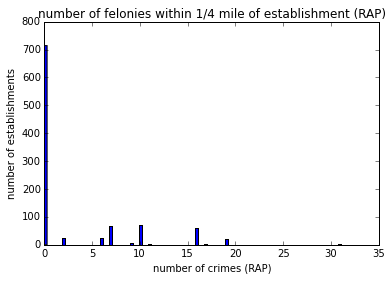

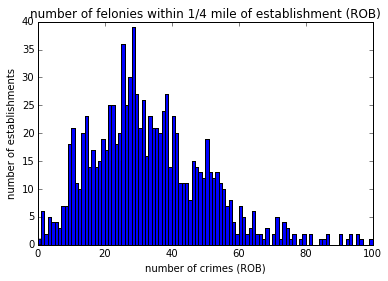

In [319]:
# show crime index histogram for each crime type

for ref in felony_ref.code:
    fig, ax = plt.subplots()
    ax.set_title('number of felonies within 1/4 mile of establishment (' + ref + ')')
    ax.set_xlabel('number of crimes (' + ref + ')')
    ax.set_ylabel('number of establishments')
    H = ax.hist(yelpcrimedf[ref], bins=100, fill=True)
    

In [172]:
# summary stats for each crime index by type

yelpcrimedf[felony_ref.code].describe()

,BUR,ASS,LAR,GTA,MUR,RAP,ROB
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,40.875000,32.553000,251.316000,8.838000,0.367000,3.01400,32.803000
std,22.128512,18.173758,142.813767,4.064761,0.738144,5.56442,17.070723
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000
25%,26.000000,21.000000,151.000000,6.000000,0.000000,0.00000,21.000000
50%,39.000000,29.000000,230.000000,9.000000,0.000000,0.00000,30.000000
75%,52.000000,39.000000,307.500000,12.000000,0.000000,6.00000,42.250000
max,141.000000,108.000000,823.000000,21.000000,4.000000,31.00000,100.000000


In [6]:
# create category aliases using Category data

category_alias_unpacker = lambda x: re.findall("alias='(\w+)'", x)

yelpcrimedf['cat_alias']=yelpcrimedf['categories'].apply(category_alias_unpacker)

In [821]:
from ast import literal_eval
literal_eval(yelpcrimedf.neighborhoods[1])

['Midtown West', "Hell's Kitchen"]

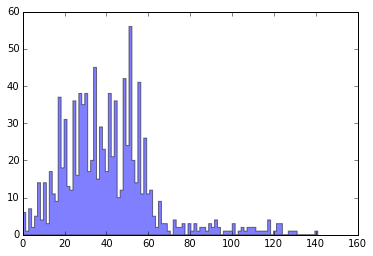

In [8]:
# histogram of crime scores

fig, ax = plt.subplots()

H = ax.hist(yelpcrimedf['BUR'], bins=100, alpha=0.5, histtype='stepfilled')

/Users/Heikal/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


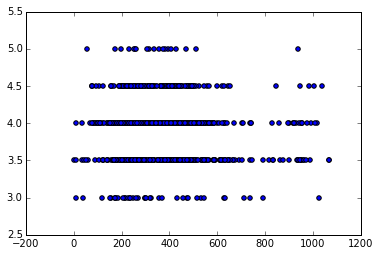

In [12]:
# scatterplot of crime score vs ratings

fig, ax = plt.subplots()
im = ax.scatter(yelpcrimedf['crime_score'], crimeindexdf['rating'],  cmap=plt.cm.jet)

In [15]:
#need a way to easily slice across categories

#build list of unique category aliases

unique_cat_alias=[]
for x in crimeindexdf.cat_alias:
    for y in x:
        unique_cat_alias.append(y)
unique_cat_alias=list(set(unique_cat_alias))

    

In [51]:
#create function to take in category name as input and creates crime index df for that category as output